# vgg16 transfer learn with sgd momentum and standardize data

only last prediction layer is trined

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
from torchinfo import summary
from pytorch_data_augmentation import load_data, normalize_data
from typing import cast, List, Union

# Set random seed for reproducibility
torch.manual_seed(42)
cudnn.benchmark = True
# cudnn.deterministic = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters

In [2]:
BATCH_SIZE = 128
IMAGE_SIZE = 128

# Load Data

In [3]:
train_ds, val_ds = load_data(IMAGE_SIZE)

In [4]:
class_names = train_ds.datasets[0].classes
NUM_CLASSES = len(class_names)
print(f"Number of classes: {NUM_CLASSES}")
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")

Number of classes: 37
Number of training samples: 6248
Number of validation samples: 1101


# Calculating standardization parameters

In [5]:
# # Calculate the mean and std per channel
# mean = torch.zeros(3)
# std = torch.zeros(3)

# for i in range(len(train_ds)):
#     img, _ = train_ds[i]
#     # img = F.to_tensor(img)
#     mean += torch.mean(img, dim=(1, 2))
#     std += torch.std(img, dim=(1, 2))

# mean /= len(train_ds)
# std /= len(train_ds)

# print("Mean per channel:", mean)
# print("Std per channel:", std)

# # Mean per channel: tensor([0.4811, 0.4490, 0.3965]) wrong!!!
# # Std per channel: tensor([0.2225, 0.2198, 0.2219]) wromg!!!
# # Caution: defining above values to new_mean tensor result in new_mean is equal to mean
# # Reason: precision of float is 4 decimals by default in print options
# # Solution: mean.numpy() displays float32 and mean[0].item() displays float64

# print("Real Mean per channel:", mean.numpy())
# print("Real Std per channel:", std.numpy())
# # Real Mean per channel: [0.4810741  0.44897535 0.3964732 ]
# # Real Std per channel: [0.22246653 0.21981163 0.2218984 ]

In [6]:
mean = torch.tensor([0.4810741, 0.44897535, 0.3964732])
std = torch.tensor([0.22246653, 0.21981163, 0.2218984])

# Standardize dataset

In [7]:
# class TransformDataset(Dataset):
#     def __init__(self, dataset, transform=None):
#         self.dataset = dataset
#         self.transform = transform

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx):
#         img, label = self.dataset[idx]
#         if self.transform:
#             img = self.transform(img)
#         return img, label

# additional_transform = v2.Normalize(mean, std)
# train_ds = TransformDataset(train_ds, transform=additional_transform)
# val_ds = TransformDataset(val_ds, transform=additional_transform)

train_ds, val_ds = normalize_data(train_ds, val_ds, mean, std)


# DataLoader

In [8]:
dataset_sizes = {'train': len(train_ds), 'val': len(val_ds)}
# Create data loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, prefetch_factor=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, prefetch_factor=2)
dataloaders = {'train': train_loader, 'val': val_loader}

# visualization

In [9]:
batch, classes = next(iter(dataloaders['train']))

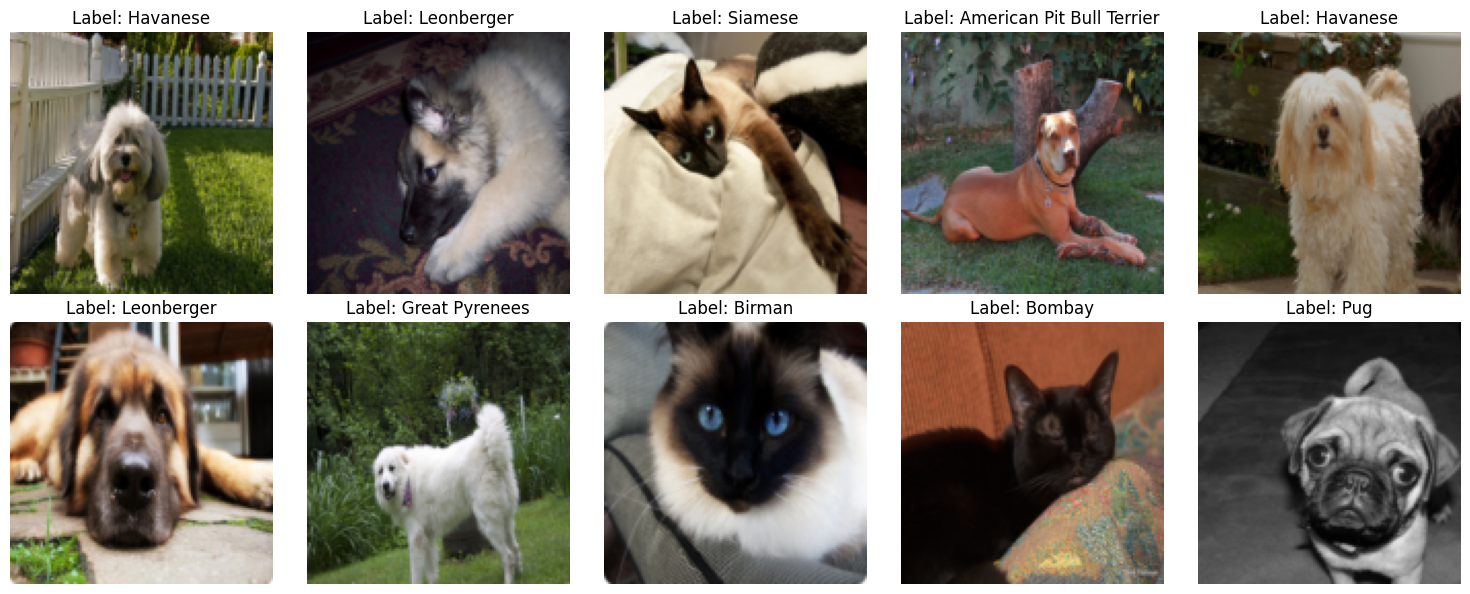

In [10]:
# Visualize 10 images from batch

r=2;c=5
fig, axs = plt.subplots(r, c, figsize=(3*c, 3*r))
for i in range(r*c):
    image = batch[i]
    label = classes[i]
    image = image.numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    axs[i // c, i % c].imshow(image)
    axs[i // c, i % c].set_title(f"Label: {class_names[torch.argmax(label).item()]}")
    axs[i // c, i % c].axis('off')

plt.tight_layout()
plt.show()

# Functions

## Training the model

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a directory to save training checkpoints
    best_model_params_path = './5_torch_vgg16_transfer_learn.pth'

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels.float())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == torch.argmax(labels,1))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

## Visualizing the model predictions
Generic function to display predictions for a few images


In [12]:
def visualize_model(model, num_images=6, batch_num=0):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for batch_counter, (inputs, labels) in enumerate(dataloaders['val']):
            if batch_counter == batch_num:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                preds = torch.argmax(outputs, 1)
                labelsss = torch.argmax(labels, 1)

                fig, axs = plt.subplots(num_images//5, 5, figsize=(3*5, int(3*(num_images//5))))
                for ax in axs.flat:
                    ax.axis('off')

                for img_count in range(inputs.size()[0]):
                    # imshow(inputs.cpu().data[img_count])
                    inp = inputs.cpu().data[img_count]
                    inp = inp.numpy().transpose((1, 2, 0))
                    inp = std * inp + mean
                    inp = np.clip(inp, 0, 1)
                    axs[img_count//5, img_count%5].imshow(inp)
                    axs[img_count//5, img_count%5].set_title(f'predicted: {class_names[preds[img_count]]} \n true: {class_names[labelsss[img_count]]}')

                    if img_count == num_images-1:
                        model.train(mode=was_training)
                        plt.tight_layout()
                        plt.show()
                        return

# VGG16 Model

In [13]:
model = models.vgg16(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False
# Parameters of newly constructed modules have requires_grad=True by default
model.classifier[6] = nn.Linear(4096, NUM_CLASSES)
model = model.to('cuda')

In [14]:
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE),verbose=0,
    col_names=["output_size", "num_params", "trainable"],
    row_settings=["var_names"],)

Layer (type (var_name))                  Output Shape              Param #                   Trainable
VGG (VGG)                                [128, 37]                 --                        Partial
├─Sequential (features)                  [128, 512, 4, 4]          --                        False
│    └─Conv2d (0)                        [128, 64, 128, 128]       (1,792)                   False
│    └─ReLU (1)                          [128, 64, 128, 128]       --                        --
│    └─Conv2d (2)                        [128, 64, 128, 128]       (36,928)                  False
│    └─ReLU (3)                          [128, 64, 128, 128]       --                        --
│    └─MaxPool2d (4)                     [128, 64, 64, 64]         --                        --
│    └─Conv2d (5)                        [128, 128, 64, 64]        (73,856)                  False
│    └─ReLU (6)                          [128, 128, 64, 64]        --                        --
│    └─Conv2d (7

# Train and evaluate

In [15]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.5 every 6 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=6, gamma=0.5)

In [16]:
VGG16_model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 2.0939 Acc: 0.4512
val Loss: 0.7450 Acc: 0.8002

Epoch 1/14
----------
train Loss: 0.8185 Acc: 0.7529
val Loss: 0.5952 Acc: 0.8347

Epoch 2/14
----------
train Loss: 0.6959 Acc: 0.7836
val Loss: 0.5496 Acc: 0.8356

Epoch 3/14
----------
train Loss: 0.6393 Acc: 0.7996
val Loss: 0.5242 Acc: 0.8429

Epoch 4/14
----------
train Loss: 0.5976 Acc: 0.8153
val Loss: 0.4998 Acc: 0.8474

Epoch 5/14
----------
train Loss: 0.5623 Acc: 0.8212
val Loss: 0.4912 Acc: 0.8510

Epoch 6/14
----------
train Loss: 0.5384 Acc: 0.8257
val Loss: 0.4848 Acc: 0.8456

Epoch 7/14
----------
train Loss: 0.5208 Acc: 0.8300
val Loss: 0.4767 Acc: 0.8492

Epoch 8/14
----------
train Loss: 0.5004 Acc: 0.8417
val Loss: 0.4783 Acc: 0.8474

Epoch 9/14
----------
train Loss: 0.4905 Acc: 0.8369
val Loss: 0.4752 Acc: 0.8510

Epoch 10/14
----------
train Loss: 0.4969 Acc: 0.8355
val Loss: 0.4703 Acc: 0.8510

Epoch 11/14
----------
train Loss: 0.4775 Acc: 0.8464
val Loss: 0.4672 Acc: 0.8510

Ep

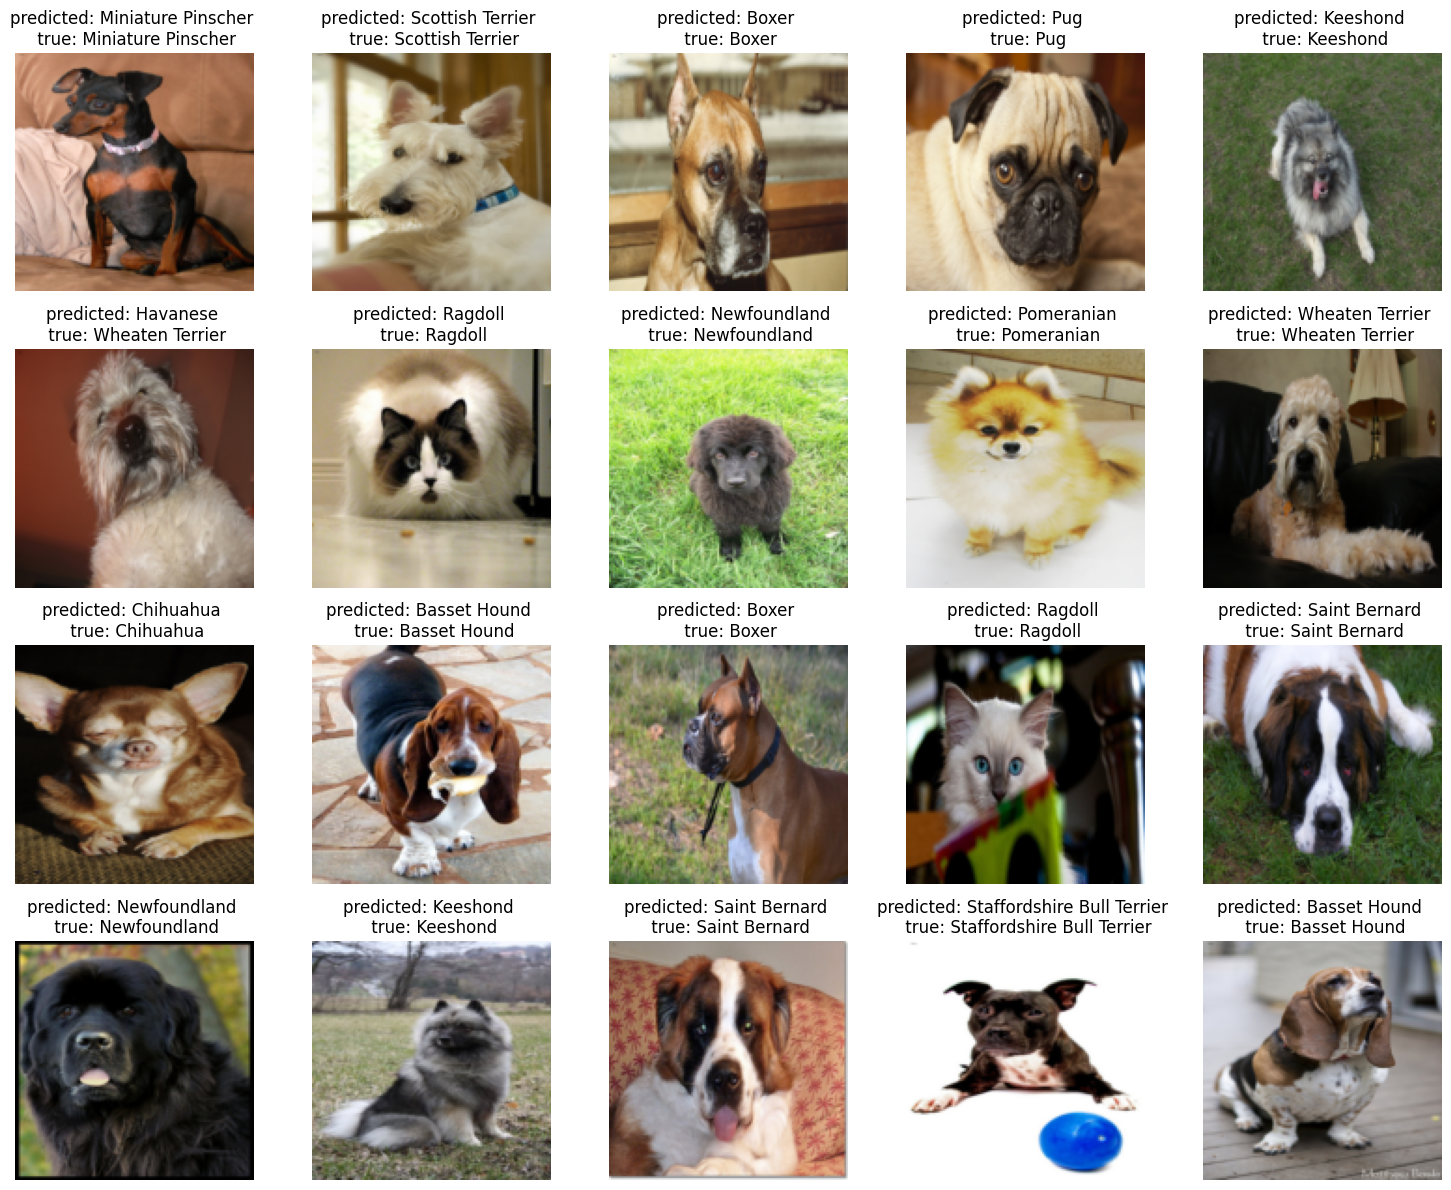

In [17]:
visualize_model(VGG16_model, num_images=20, batch_num=1)

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
# # prompt: copy weights file to my drive

# !cp /content/5_torch_vgg16_transfer_learn.pth /content/drive/MyDrive/
